<a href="https://colab.research.google.com/github/TIANBOQIU/AppliedDeepLearning/blob/master/HW2_v0_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -q tf-nightly-2.0-preview

In [2]:
from __future__ import absolute_import, division, print_function
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import numpy as np
import zipfile

from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16

print(tf.__version__)

Limited tf.compat.v2.summary API due to missing TensorBoard installation
Limited tf.summary API due to missing TensorBoard installation
2.0.0-dev20190214


In [3]:
!wget https://storage.googleapis.com/applied-dl/mini_flowers.zip \
  -O /tmp/mini_flowers.zip

--2019-02-14 22:44:43--  https://storage.googleapis.com/applied-dl/mini_flowers.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.206.128, 2a00:1450:400c:c04::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.206.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40110537 (38M) [application/zip]
Saving to: ‘/tmp/mini_flowers.zip’

/tmp/mini_flowers.z 100%[===================>]  38.25M  24.2MB/s    in 1.6s    

2019-02-14 22:44:45 (24.2 MB/s) - ‘/tmp/mini_flowers.zip’ saved [40110537/40110537]



In [4]:
# Data
local_zip = '/tmp/mini_flowers.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/mini_flowers')
zip_ref.close()
base_dir = '/tmp/mini_flowers'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
n_classes = len(os.listdir(train_dir))
train_paths = [os.path.join(train_dir, i) for i in os.listdir(train_dir)]
val_paths = [os.path.join(val_dir, i) for i in os.listdir(val_dir)]
n_train = sum([len(os.listdir(i)) for i in train_paths])
n_val = sum([len(os.listdir(i)) for i in val_paths])
data_gen = ImageDataGenerator(rescale=1./255)
BATCH_SIZE=32
TARGET_SHAPE=150
train_data = data_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                         directory=train_dir,
                                         shuffle=True,
                                         target_size=(TARGET_SHAPE,TARGET_SHAPE),
                                         class_mode='categorical')
val_data = data_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                         directory=val_dir,
                                         shuffle=True,
                                         target_size=(TARGET_SHAPE,TARGET_SHAPE),
                                         class_mode='categorical')



Found 1000 images belonging to 5 classes.
Found 500 images belonging to 5 classes.


In [7]:
batch_train_images, batch_train_labels = next(train_data)
batch_train_images.shape
batch_train_labels[4]
train_data.batch_size

32

In [0]:
# feature extraction
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))

def extract_features(data_gen, sample_count):
  features = np.zeros(shape=(sample_count, 4, 4, 512))
  labels = np.zeros(shape=(sample_count,5))
  i = 0
  BATCH_SIZE = data_gen.batch_size
  for images_batch, labels_batch in data_gen:
    features[i*BATCH_SIZE: (i+1)*BATCH_SIZE] = conv_base.predict(images_batch)
    labels[i*BATCH_SIZE: (i+1)*BATCH_SIZE] = labels_batch
    i += 1
    if i * BATCH_SIZE >= sample_count:
      break
    return features, labels
train_features, train_labels = extract_features(train_data, n_train)
val_features, val_labels = extract_features(val_data, n_val)

In [17]:
print(train_features.shape)
print(train_labels.shape)

(1000, 4, 4, 512)
(1000, 5)


In [19]:
# Model
train_features = np.reshape(train_features, (n_train, 4*4*512))
val_features = np.reshape(val_features, (n_val, 4*4*512))
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=4*4*512))
model.add(keras.layers.Dropout(0.5))
model.add(Dense(5, activation = 'sigmoid'))

model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = ['acc'])
history = model.fit(train_features, train_labels, epochs=50,batch_size=20, validation_data=(val_features, val_labels))

Train on 1000 samples, validate on 500 samples
Epoch 1/50
1000/1000==============================] - 1s 1ms/sample - loss: 0.0732 - acc: 0.5380 - val_loss: 0.1024 - val_acc: 0.0160
Epoch 2/50
1000/1000==============================] - 1s 850us/sample - loss: 0.0700 - acc: 0.4030 - val_loss: 0.1404 - val_acc: 0.0140
Epoch 3/50
1000/1000==============================] - 1s 856us/sample - loss: 0.0464 - acc: 0.3530 - val_loss: 0.1299 - val_acc: 0.0140
Epoch 4/50
1000/1000==============================] - 1s 841us/sample - loss: 0.0618 - acc: 0.4620 - val_loss: 0.2009 - val_acc: 0.9500
Epoch 5/50
1000/1000==============================] - 1s 831us/sample - loss: 0.0600 - acc: 0.4930 - val_loss: 0.1025 - val_acc: 0.9500
Epoch 6/50
1000/1000==============================] - 1s 831us/sample - loss: 0.0443 - acc: 0.5690 - val_loss: 0.1053 - val_acc: 0.9500
Epoch 7/50
1000/1000==============================] - 1s 829us/sample - loss: 0.0563 - acc: 0.4160 - val_loss: 0.1717 - val_acc: 0.0140
Epo

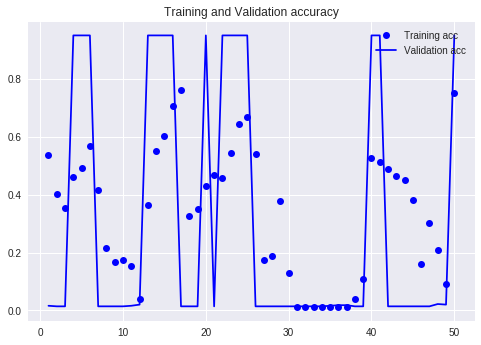

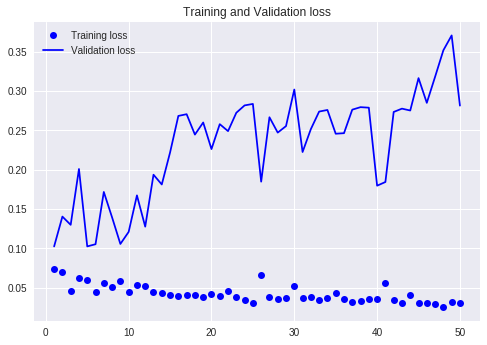

In [22]:
# Plotting the results
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc)+1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()


**We can see that the model is almost overfitting immediately.**